In [525]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, zscore, gzscore
from talib import RSI, BBANDS, MACD, ATR

from typing import Tuple, List, Dict, Any

In [526]:
START = '2013-01-01'
END = '2017-12-31'
TD_PER_MONTH = 21 # trading days per month, on average
TD_PER_YEAR = 12 * TD_PER_MONTH # trading days per year
MIN_TD = 2 * TD_PER_YEAR
# MIN_TD = 20

DATA_STORE = '../data/assets.h5'

idx = pd.IndexSlice

sns.set_style('whitegrid')


In [527]:
# load data from data store
def load_raw() -> Tuple[pd.DataFrame, pd.DataFrame]:
    with pd.HDFStore(DATA_STORE) as store:
        prices_raw = store['quandl/wiki/prices']
        stocks_raw = store['us_equities/stocks']
    return prices_raw, stocks_raw

In [528]:
prices_raw, stocks_raw = load_raw()

In [532]:
def preprocess(prices_raw: pd.DataFrame, stocks_raw: pd.DataFrame,
               min_td: int = MIN_TD, start: str = START, end: str = END) -> pd.DataFrame:
    """prepare loaded raw prices into training samples"""
    # handle prices
    prices = prices_raw.loc[
        idx[start: end, :],
        ['adj_open', 'adj_close', 'adj_high', 'adj_low', 'adj_volume']
    ].swaplevel().sort_index().rename(columns=lambda x: x.replace('adj_', ''))
    td_counts = prices.groupby(level="ticker").size()
    qualified_tickers = td_counts[td_counts > min_td].index
    prices = prices.loc[idx[qualified_tickers, :]]

    # handle stocks
    stocks = stocks_raw.loc[:, ['marketcap', 'ipoyear', 'sector']]
    stocks = stocks.loc[~stocks.index.duplicated() & stocks.sector.notnull()]
    stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
    stocks.index.name = 'ticker'

    # we only consider tickers in both stocks and prices
    prices_tickers = prices.index.get_level_values('ticker').unique()
    stocks_tickers = stocks.index.unique()
    shared_tickers = stocks_tickers.intersection(prices_tickers)
    prices = prices.loc[idx[shared_tickers, :]]
    stocks = stocks.loc[shared_tickers]

    # add trade volume columns
    prices['dollar_vol_raw'] = prices['close'] * prices['volume']
    prices['dollar_vol'] = prices['dollar_vol_raw'].groupby(level='ticker').rolling(window=21).mean().reset_index(level=0, drop=True)
    prices['dollar_vol_rank'] = prices.dollar_vol.groupby(level='date').rank(ascending=False)

    # add features from ta-lib
    prices['rsi'] = prices.groupby(level='ticker', group_keys=False).close.apply(RSI)#.reset_index(level=0, drop=True)
    def _calc_bb(group):
        high, mid, low = BBANDS(group)
        return pd.DataFrame({'bb_high': high, 'bb_low': low})
    prices = prices.join(prices.groupby(level='ticker', group_keys=False).close.apply(_calc_bb))#.reset_index(level=0, drop=True))
    prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
    prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)
    def _calc_atr(group):
        df = ATR(group.high, group.low, group.close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    prices['atr'] = prices.groupby(level='ticker', group_keys=False).apply(_calc_atr)
    def _calc_macd(group):
        macd = MACD(group)[0]
        return macd.sub(macd.mean()).div(macd.std())
    prices['macd'] = prices.groupby(level='ticker', group_keys=False).close.apply(_calc_macd)

    #generate lagged returns
    lags = [1, 5, 10, 21, 42, 63]
    # returns = prices.groupby(level='ticker').close.pct_change()
    # percentiles=[.0001, .001, .01]
    # percentiles+= [1-p for p in percentiles]
    # returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')
    q = 0.0001
    for lag in lags:
        # return_Nd: 在第 M 日的 return_Nd 数值, 表示若 N 天前开始持有该标的的 long position, 到第 M 日时, 每日(几何)平均的收益百分比
        # (即假定每日收益相同, 多日复利后达到第 M 日的价格)
        prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                    .pct_change(lag)
                                    .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                           upper=x.quantile(1 - q)))
                                    .add(1)
                                    .pow(1 / lag)
                                    .sub(1)
                                    )
    # 目前仍不太懂下面这些字段的语义
    for t in [1, 2, 3, 4, 5]:
        for lag in [1, 5, 10, 21]:
            prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                               [f'return_{lag}d'].shift(t * lag))
    # target returns
    # target_5d: 在第 M 日的 target_5d 数值, 表示若从第 M 日起持有 long position, 5 日后清仓, 每日(几何)平均的收益百分比
    # 也许可以称为日化收益? (类似年化)
    for t in [1, 5, 10, 21]:
        prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

    # dummies
    prices['year'] = prices.index.get_level_values('date').year
    prices['month'] = prices.index.get_level_values('date').month
    x = prices.join(stocks['sector'])
    prices = pd.get_dummies(x, columns=['year', 'month', 'sector'], drop_first=True, prefix=['year', 'month', ''], prefix_sep=['_', '_', ''], dtype=np.uint8)
    return prices, stocks

In [533]:
prices, stocks = preprocess(prices_raw, stocks_raw)

In [534]:
prices.to_hdf("../data/linear.h5", 'model_data')

In [535]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('FLWS', Timestamp('2013-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   open                   float64
 1   close                  float64
 2   high                   float64
 3   low                    float64
 4   volume                 float64
 5   dollar_vol_raw         float64
 6   dollar_vol             float64
 7   dollar_vol_rank        float64
 8   rsi                    float64
 9   bb_high                float64
 10  bb_low                 float64
 11  atr                    float64
 12  macd                   float64
 13  return_1d              float64
 14  return_5d              float64
 15  return_10d             float64
 16  return_21d             float64
 17  return_42d             float64
 18  return_63d             float64
 19  return_1d_lag1         float64
 20  return_5d_lag1 

# verifications

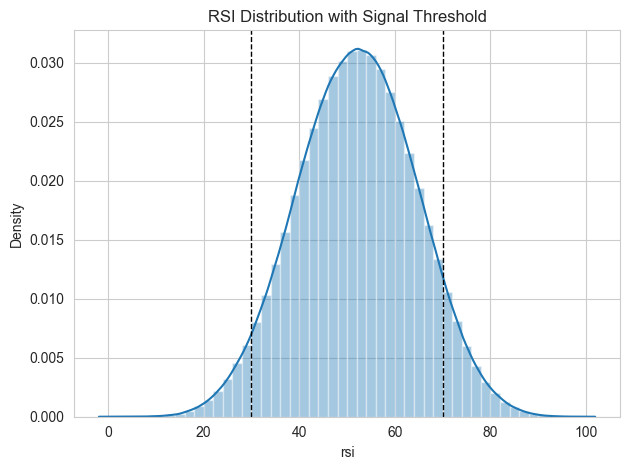

In [515]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

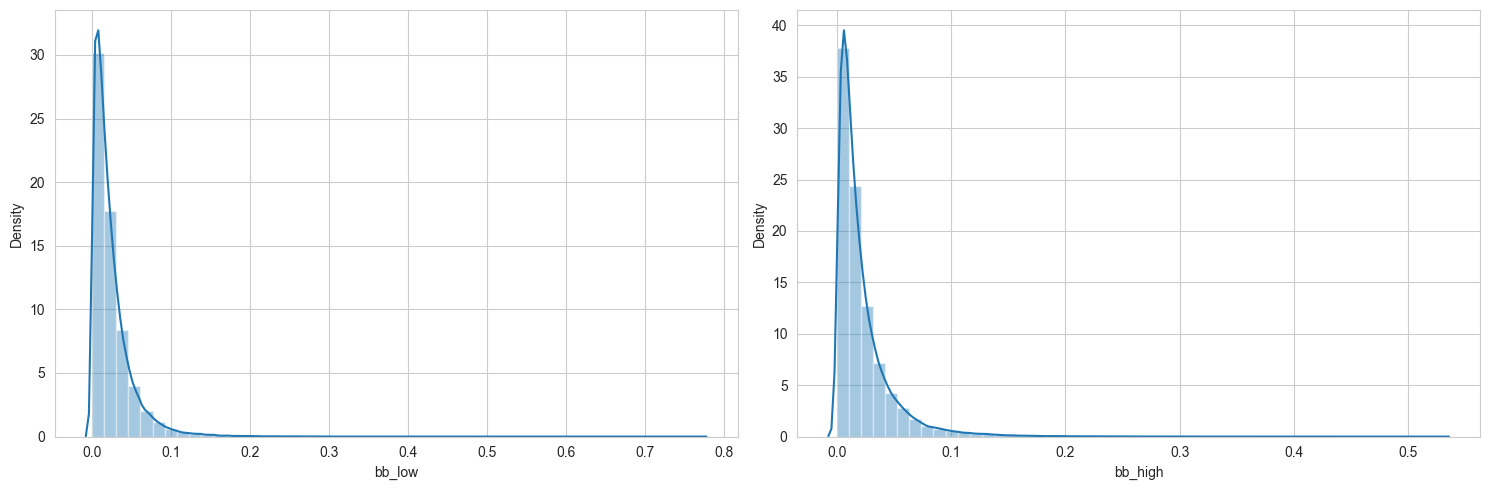

In [516]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

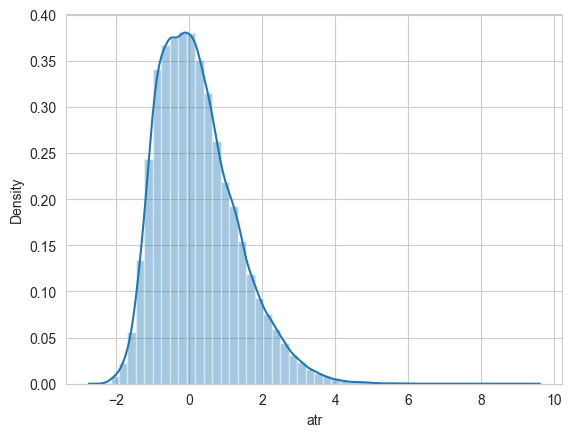

In [517]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

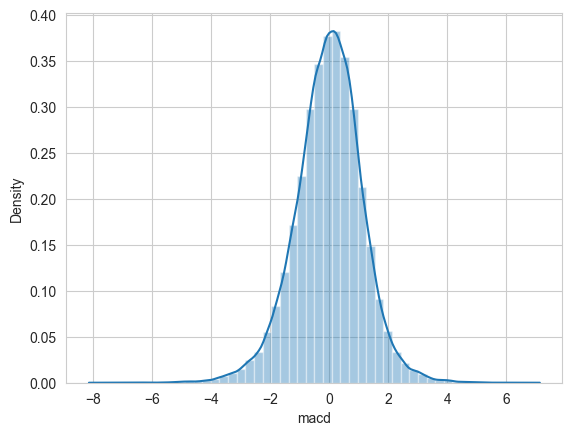

In [518]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

In [521]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2904233 entries, ('FLWS', Timestamp('2013-01-02 00:00:00')) to ('ZTS', Timestamp('2017-12-29 00:00:00'))
Data columns (total 69 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   open                   float64
 1   close                  float64
 2   high                   float64
 3   low                    float64
 4   volume                 float64
 5   dollar_vol_raw         float64
 6   dollar_vol             float64
 7   dollar_vol_rank        float64
 8   rsi                    float64
 9   bb_high                float64
 10  bb_low                 float64
 11  atr                    float64
 12  macd                   float64
 13  return_1d              float64
 14  return_5d              float64
 15  return_10d             float64
 16  return_21d             float64
 17  return_42d             float64
 18  return_63d             float64
 19  return_1d_lag1         float64
 20  return_5d_lag1 